# Runners

@[Chaoming Wang](https://github.com/chaoming0625)
@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)

## Runners for Dynamical Systems

The convenient simulation interfaces for dynamical systems in BrainPy are implemented in ``brainpy.simulation.runner``. Currently, we implement two kinds of runner: ``DSRunner`` and ``ReportRunner``. They have their respective advantages. 

In [41]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')

## Initializing a runner

Generally, we can initialize a runner with the format of:

```python
SomeRunner(target=instance_of_dynamical_system,
           inputs=inputs_for_target_variables,
           monitors=interested_variables_to_monitor,
           dyn_vars=dynamical_changed_variables,
           jit=enable_jit_or_not)
```

In which
- ``target`` specifies the model to be simulated. It must an instance of [brainpy.DynamicalSystem](../apis/auto/simulation/generated/brainpy.simulation.brainobjects.DynamicalSystem.rst). 
- ``monitors`` is used to define target variables in the model. During the simulation, the history values of the monitored variables will be recorded. More information can be found in the [Monitors](monitors.ipynb) tutorial.
- ``inputs`` is used to define the input operations for specific variables. It will be expanded in the [Inputs](inputs.ipynb) tutorial.
- ``dyn_vars`` is used to specify all the dynamically changed [variables](../tutorial_math/variables.ipynb) used in the ``target`` model.
- ``jit`` determines whether to use [JIT compilation](../tutorial_math/compilation.ipynb) during the simulation.

Here we define an E/I balanced network as the simulation model. 

In [42]:
class EINet(bp.Network):
  def __init__(self, num_exc=3200, num_inh=800, method='exp_auto'):
    # neurons
    pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.)
    E = bp.dyn.LIF(num_exc, **pars, method=method)
    I = bp.dyn.LIF(num_inh, **pars, method=method)
    E.V[:] = bm.random.randn(num_exc) * 2 - 55.
    I.V[:] = bm.random.randn(num_inh) * 2 - 55.

    # synapses
    E2E = bp.dyn.ExpCOBA(E, E, bp.conn.FixedProb(prob=0.02),
                         E=0., g_max=0.6, tau=5., method=method)
    E2I = bp.dyn.ExpCOBA(E, I, bp.conn.FixedProb(prob=0.02),
                         E=0., g_max=0.6, tau=5., method=method)
    I2E = bp.dyn.ExpCOBA(I, E, bp.conn.FixedProb(prob=0.02),
                         E=-80., g_max=6.7, tau=10., method=method)
    I2I = bp.dyn.ExpCOBA(I, I, bp.conn.FixedProb(prob=0.02),
                         E=-80., g_max=6.7, tau=10., method=method)

    super(EINet, self).__init__(E2E, E2I, I2E, I2I, E=E, I=I)

Then we will wrap it in different runners for dynamic simulation.

## ``brainpy.DSRunner``

``brainpy.DSRunner`` aims to provide model simulation with an outstanding performance. It takes advantage of the [structural loop primitive](../tutorial_math/control_flows.ipynb) to lower the model onto the XLA devices. 

In [3]:
net = EINet()

runner = bp.DSRunner(net, 
                     monitors=['E.spike'],
                     inputs=[('E.input', 20.), ('I.input', 20.)],
                     jit=True)
runner.run(100.)

  0%|          | 0/1000 [00:00<?, ?it/s]

1.2974658012390137

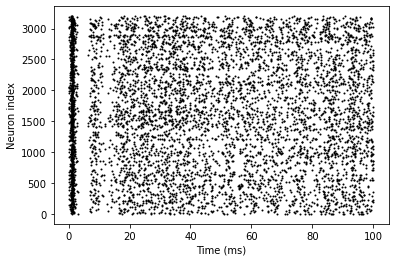

In [4]:
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], show=True)

Note that if the parameter ``jit`` is set to ``True``, then all the variables will be JIT compiled and thus the system cannot be debugged by Python debugging tools. For debugging, users can set ``jit=False``.

## ``brainpy.ReportRunner``

``brainpy.ReportRunner`` aims to provide a Pythonic interface for model debugging. Users can use the standard Python debugging tools when simulating the model with ``ReportRunner``.

The drawback of the ``brainpy.ReportRunner`` is that it is relatively slow. It iterates the loop along times during the simulation.

In [4]:
net = EINet()

runner = bp.ReportRunner(net, 
                         monitors=['E.spike'],
                         inputs=[('E.input', 20.), ('I.input', 20.)],
                         jit=True)
runner.run(100.)

  0%|          | 0/1000 [00:00<?, ?it/s]

3.402564764022827

We can see from the output that the time spent for simulation through ``ReportRunner`` is longer than that through ``DSRunner``.

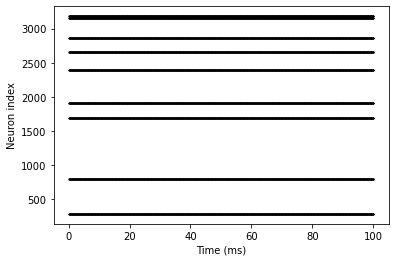

In [5]:
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], show=True)

## Runners for Neural Network Training